energy:  1.6021765300000002e-15 J lambda0:  1.2398420442295194e-10 m dx:  5e-07 m z:  0.5 m N:  0.00403277177384896 dimensionless H:  (2048, 2048) H max:  (1+0j) dimensionless H min:  (-0.9999999978396205-6.573248139342716e-05j) dimensionless


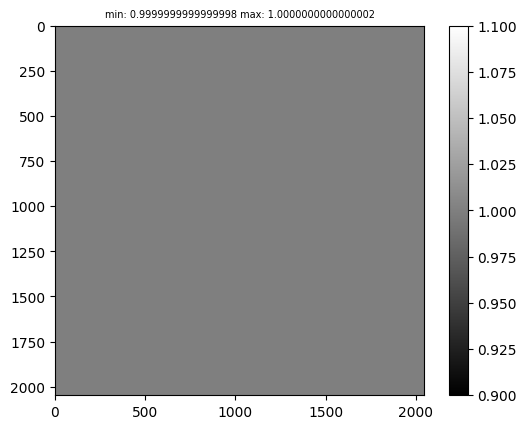

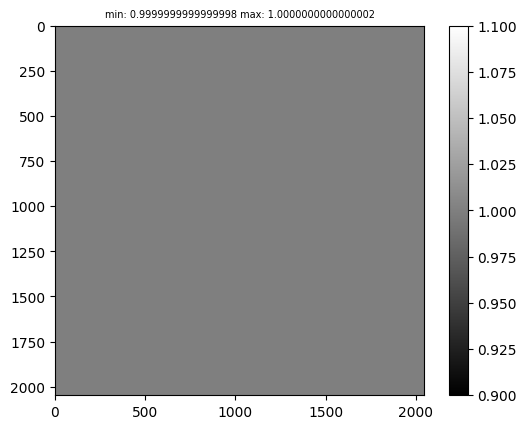

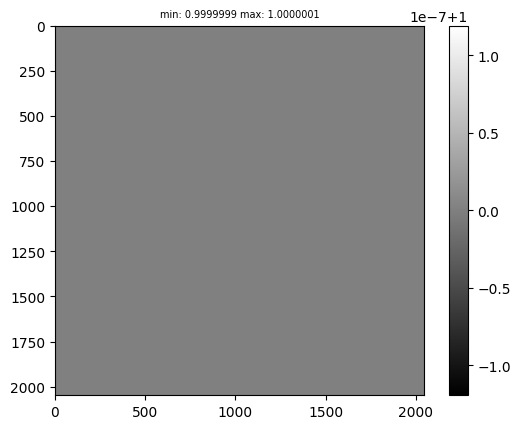

In [11]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from skimage import io as io
import lib
import utils
import numpy as np

energy = 10
z = 0.5
pv = 5e-7
fname_data = '/home/hailudaw/hailudaw/ml_for_phase/propagations_2000/propagation_260.tif'
input = io.imread(fname_data)
px, py = input.shape

# first method: modified from a paper
def fresnel_operator(px, py, pv, z, energy):
    from numpy.fft import fftfreq
    from numpy import pi 
    import quantities as pq
    energy = energy * pq.keV
    energy = energy.rescale(pq.J)
    #planck constant
    h = 6.62607004e-34 * pq.J * pq.s
    #speed of light
    c = 299792458 * pq.m / pq.s
    #wave length
    lambda0 = h * c / energy
    lambda0 = lambda0.rescale(pq.m)
    #sampling size
    dx = pv * pq.m
    #propagation distance
    z = z * pq.m
    #fresnel number
    N = dx**2 / (lambda0 * z)
    #fresnel number
    N = N.rescale(pq.dimensionless)
    
    #fresnel operator
    fx = fftfreq(px, d=pv) * pq.m**-1
    fy = fftfreq(py, d=pv) * pq.m**-1

    Fx, Fy = np.meshgrid(fx, fy)
    H = np.exp(-1j * pi * lambda0 * z * (Fx ** 2 + Fy ** 2))
    print("energy: ", energy, "lambda0: ", lambda0, "dx: ", dx, "z: ", z, "N: ", N, "H: ", H.shape, "H max: ", H.max(), "H min: ", H.min())
    return H

lib.visualize([fresnel_operator(px, py, pv, z, energy)])

# second method: modified from pyphase
def simple_propagator(nfx = px, nfy = py, ND = 1, pxs = [pv, pv], Lambda = 1.2398420442295194e-10, z = [z]):
    """
    Creates a Fresnel propagator.
    
    Parameters
    ----------
    pxs : float
        Pixel size in µm.
    Lambda : float
        Wavelength in m.
    z : float
        Effective propagation distance in m.
        
    Returns
    -------
    H : nparray
        Fresnel propagator.
    
    Notes
    -----
    Temporary implementation by Y. Zhang. Will be integrated with the
    propagator module.
    
    """
    
    # TODO: need to be replaced by the propagator class
    # TODO: Needs refactoring to meet coding standards
    # Generates the ifftshift version of the propagators
    x = np.arange(-np.fix(nfx / 2), np.ceil(nfx / 2))
    y = np.arange(-np.fix(nfy / 2), np.ceil(nfy / 2))
    fx = np.fft.ifftshift(x / (nfx * pxs[1])) #pxs[1] throws error: invalid index to scalar variable. Replaced with pxs
    fy = np.fft.ifftshift(y / (nfy * pxs[0]))
    Fx, Fy = np.meshgrid(fx, fy)
    f2 = Fx ** 2 + Fy ** 2
    H = np.zeros([ND, nfy, nfx], dtype="complex_")
    for distance in range(ND):
        H[distance,:,:] = np.exp(-1j * np.pi * Lambda * z[distance] * f2) 
    return H

lib.visualize([simple_propagator()[0]])

# third method: ganrec
def ffactor(px = px, energy = energy, z = z, pv = pv):
    lambda_p = 1.23984122e-09 / energy
    frequ_prefactor = 2 * np.pi * lambda_p * z / pv ** 2
    freq = np.fft.fftfreq(px)
    xi, eta = np.meshgrid(freq, freq)
    xi = xi.astype('float32')
    eta = eta.astype('float32')
    h = np.exp(- 1j * frequ_prefactor * (xi ** 2 + eta ** 2) / 2)
    return h
lib.visualize([ffactor()])

# Test for propagator

###### 0. Second example with simulated ground truth data

delta beta ratio:  374.00824


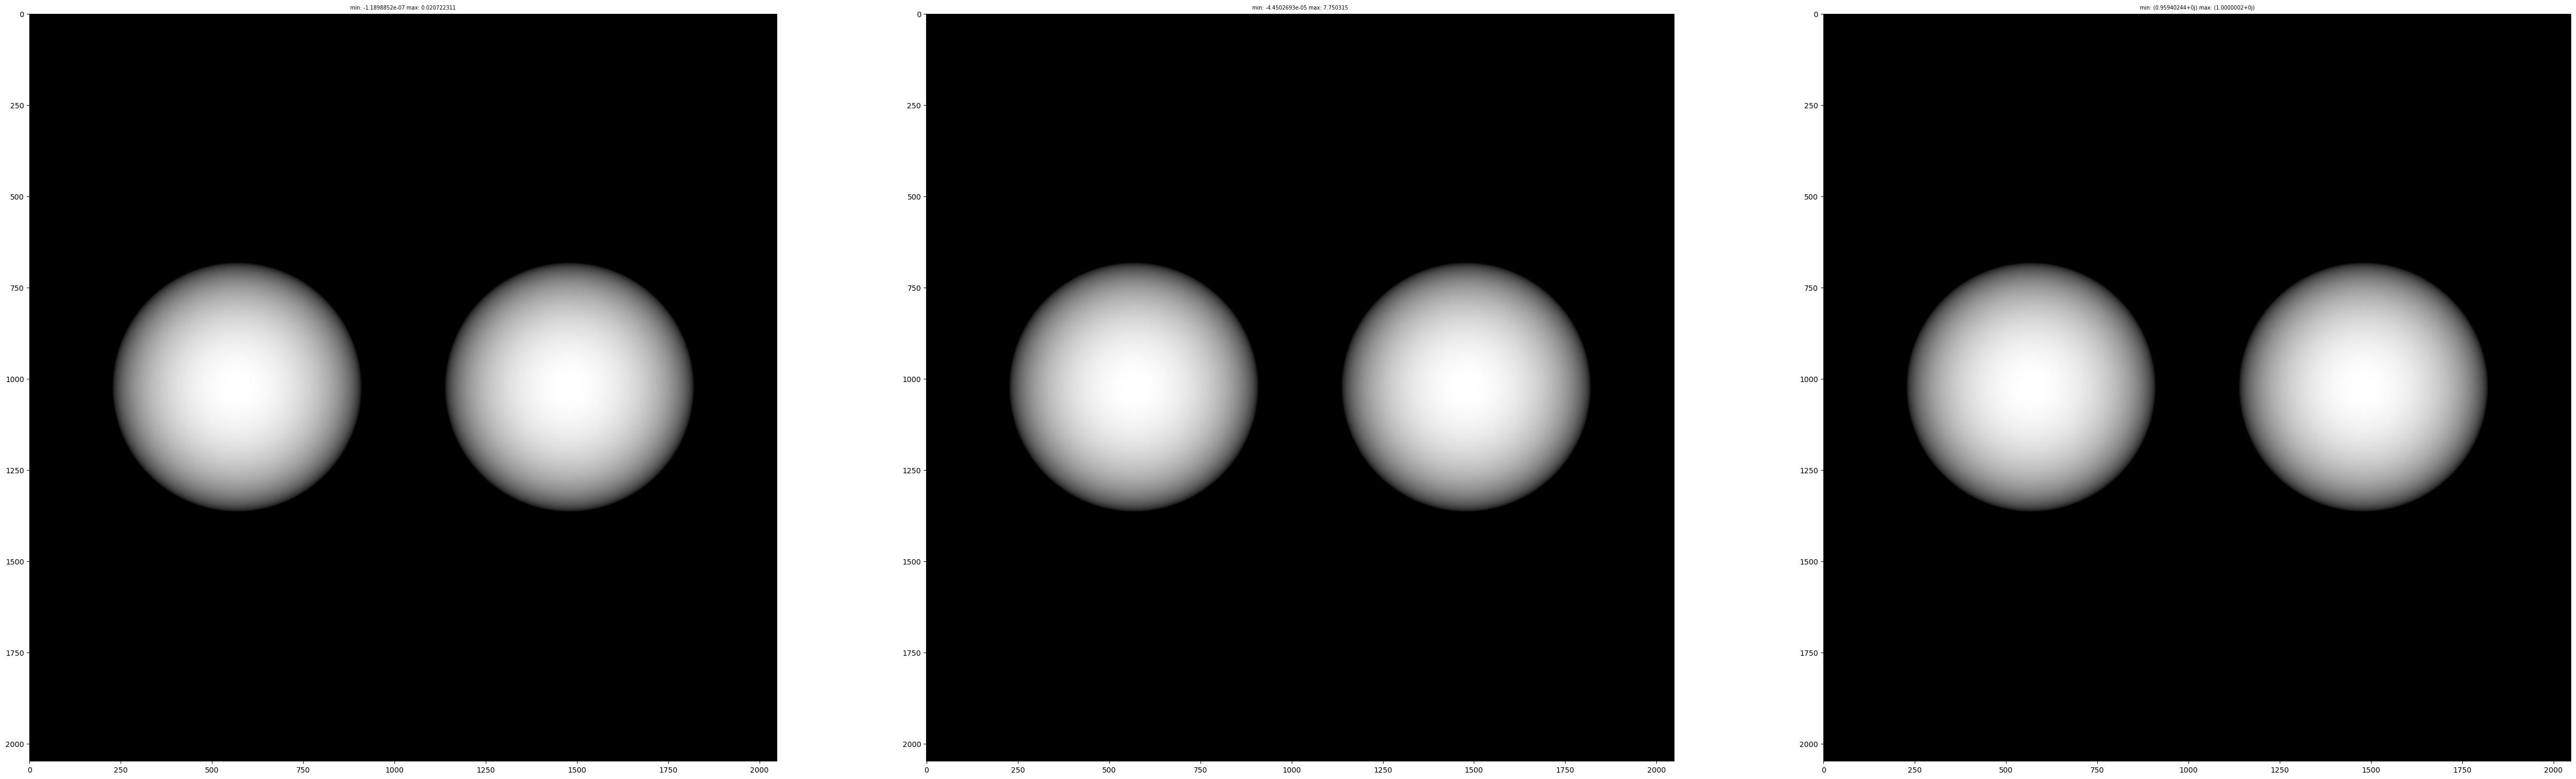

In [37]:
#phase and attenuation taken from ground truth simulation data
attenuation = '/beegfs/desy/user/jentscht/for_dawit/fresnel/groundtruth/ground_truth_projection/ground_truth_projection_01700_attenuation_6.0_keV_type_float32_2048x2048.tif'
phase = '/beegfs/desy/user/jentscht/for_dawit/fresnel/groundtruth/ground_truth_projection/ground_truth_projection_01700_phase_6.0_keV_type_float32_2048x2048.tif'
attenuation = io.imread(attenuation) * lib.wave_number(10)
phase = io.imread(phase) * lib.wave_number(10)
wave_front = np.exp(-attenuation + 1j * phase)
delat_beta_ration = np.max(phase) / np.max(attenuation)
print("delta beta ratio: ", delat_beta_ration)
lib.visualize([attenuation, phase, np.conj(wave_front)*wave_front])

In [41]:
h5_path = '/beegfs/desy/user/jentscht/for_dawit/fresnel/simulation_parameter_nexus.h5'
import lib
lib.extract_property_h5(h5_path)
energy, lam, detector_pixel_size, distance_sample_detector, fresnel_number, energy_kev = lib.get_different_properties(h5_path)


the energy is:  9.61305918e-16 J the wavelength is:  2.0663815644043505e-10 m the detector_pixel_size is:  5.5e-06 m the distance_sample_detector is:  0.14638963925113666 m the fresnel_number is:  1.0000104074856626 dimensionless


## 1. Testing the fresnel operator

energy:  6.0 z:  1463.8963925113665 pv:  5.5e-06 px:  2048 py:  2048
energy:  9.61305918e-16 J lambda0:  2.0664034070491994e-10 m dx:  5.5e-06 m z:  1463.8963925113665 m N:  9.999998370074581e-05 dimensionless H:  (2048, 2048) H max:  (1+0j) dimensionless H min:  (-0.9999999999822653-5.955628032579288e-06j) dimensionless
energy:  9.61305918e-16 J lambda0:  2.0664034070491994e-10 m dx:  5.5e-06 m z:  1463.8963925113665 m N:  9.999998370074581e-05 dimensionless H:  (2048, 2048) H max:  (1+0j) dimensionless H min:  (-0.9999999999822653-5.955628032579288e-06j) dimensionless


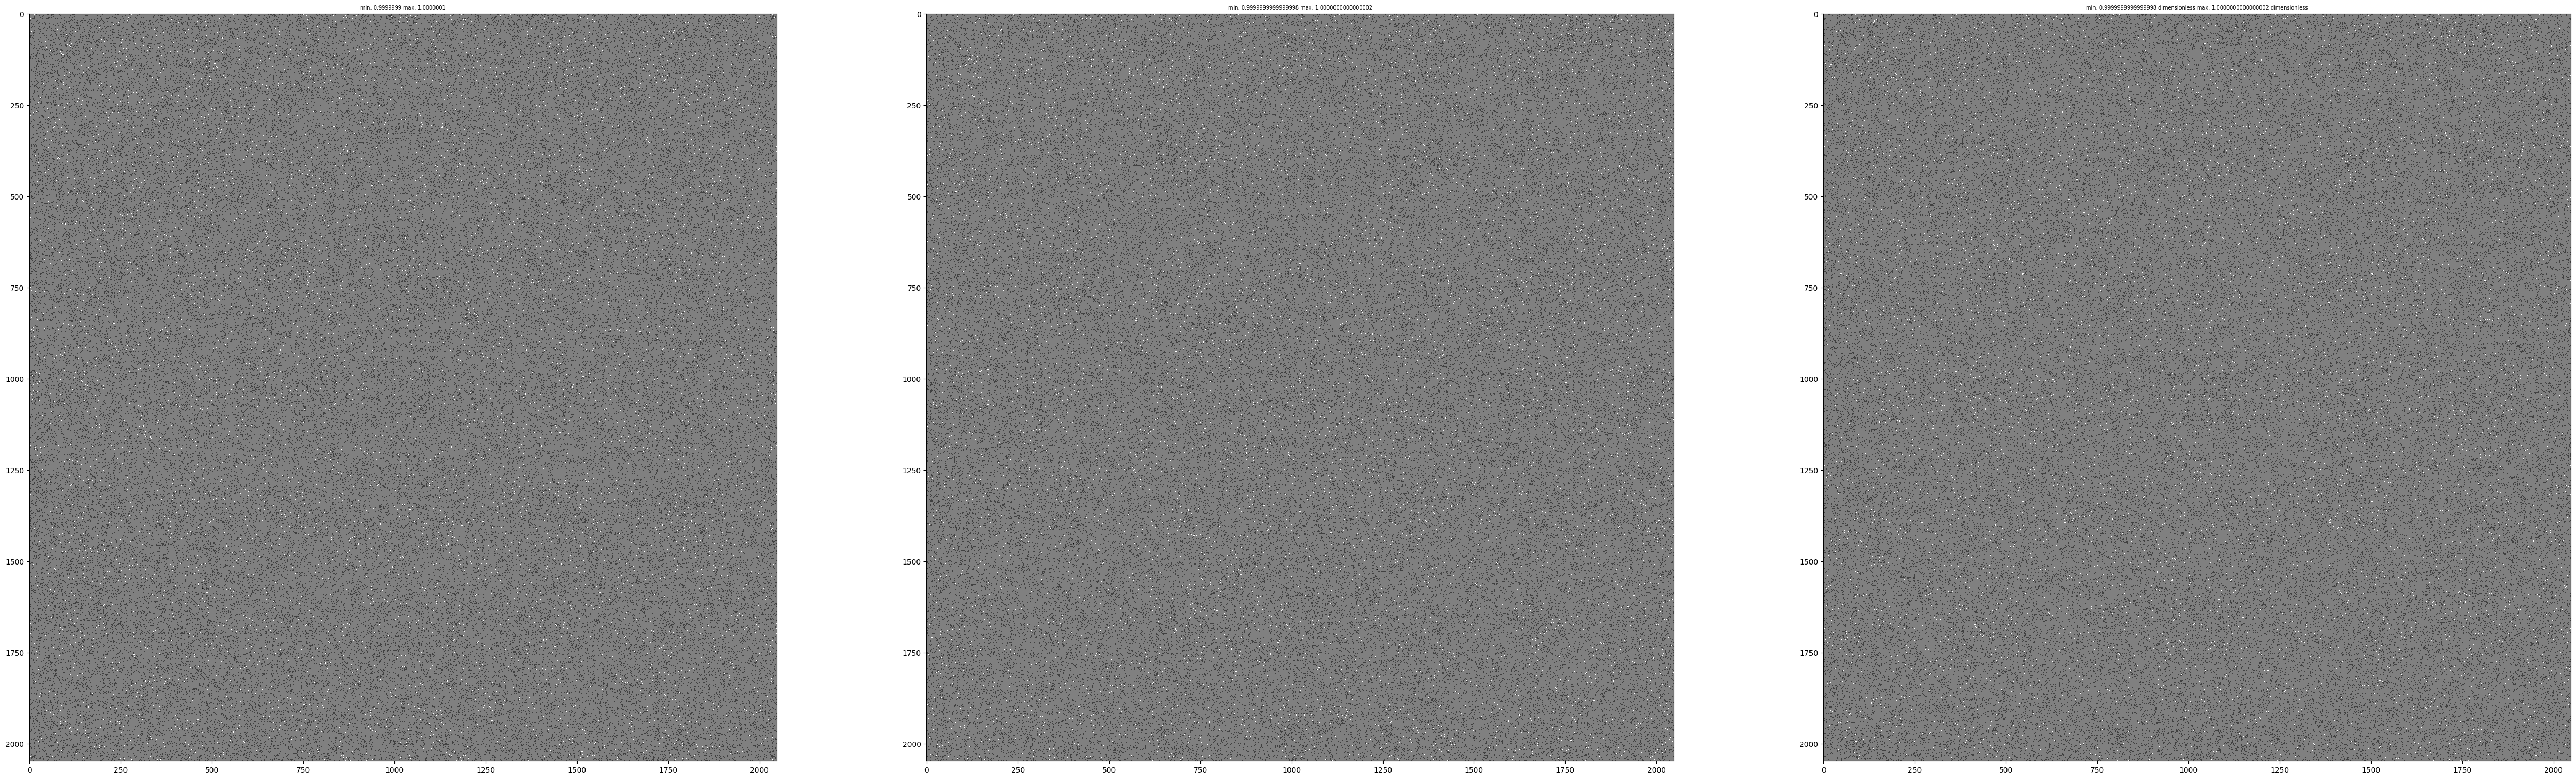

In [42]:
#visualize the different fresnel operators
energy = energy_kev.magnitude
z = distance_sample_detector.magnitude * 10000
pv = detector_pixel_size.magnitude
px, py = phase.shape
ff_ganrec = ffactor(px, energy, z, pv)
ff_pyphase = simple_propagator(px, py, 1, [pv, pv], lam.magnitude, [z])[0]
ff_paper = fresnel_operator(px, py, pv, z, energy)
lib.visualize([ffactor(px, energy, z, pv), simple_propagator(px, py, 1, [pv, pv], lam.magnitude, [z])[0], fresnel_operator(px, py, pv, z, energy)])

## 2. Propagator

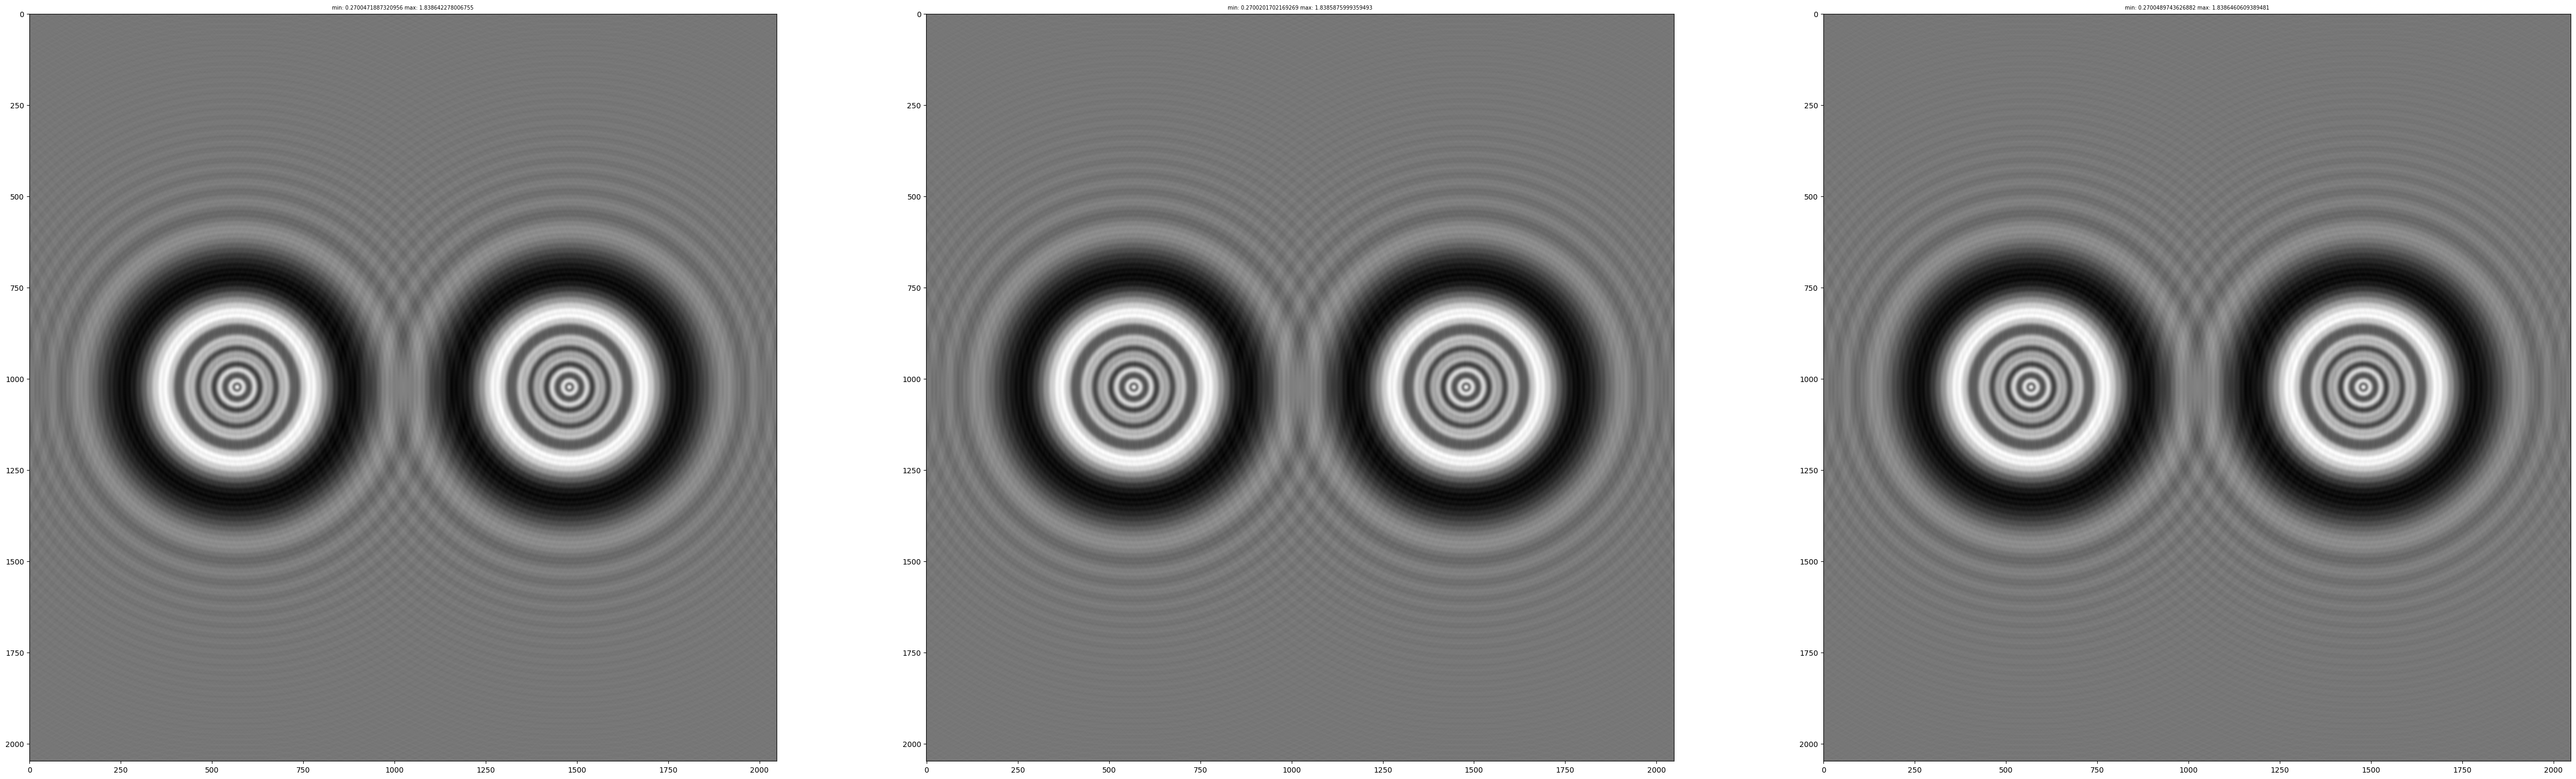

In [39]:
propagation_ganrec = np.fft.ifft2(np.fft.fft2(wave_front) * ff_ganrec)
propagation_pyphase = np.fft.ifft2(np.fft.fft2(wave_front) * ff_pyphase)
propagation_paper = np.fft.ifft2(np.fft.fft2(wave_front) * ff_paper)
lib.visualize([propagation_ganrec, propagation_pyphase, propagation_paper])

### using real data from experiment

In [8]:
import skimage.io as io
import numpy as np
import lib
import os
def grid_generator(shape_x, shape_y, upscale = 1, ps = 5.5e-06):
    """ 
    Parameters: shape_y - shape of the image in y-direction
    #             upscale - scale by which to upsample image
    #             ps - pixel size in microns
    """             
    upsample_scale = upscale;                 # Scale by which to upsample image
    nx = upsample_scale * shape_x # Image width in pixels (same as height)
    ny = upsample_scale * shape_y
    grid_size_x = ps * nx;                 # Grid size in x-direction
    grid_size_y = ps * ny;                 # Grid size in y-direction

    # Grid generation
    # Fx = np.linspace(-(nx-1)/2*(1/grid_size_x), (nx-1)/2*(1/grid_size_x), nx)
    # Fy = np.linspace(-(ny-1)/2*(1/grid_size_y), (ny-1)/2*(1/grid_size_y), ny)
    # Fx, Fy = np.meshgrid(Fx, Fy)
    # Inverse space
    fx = np.linspace(-(nx-1)/2*(1/grid_size_x), (nx-1)/2*(1/grid_size_x), nx)
    fy = np.linspace(-(ny-1)/2*(1/grid_size_y), (ny-1)/2*(1/grid_size_y), ny)
    Fx, Fy = np.meshgrid(fx, fy)
    
    return Fx, Fy

def get_all_info(path = None, idx = 1000, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1e1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """

    if path is not None:
        images = io.imread_collection(path + '/*.tif').files
        # images = sorted(glob(path + '/*.tif'))
        if type(idx) is list:
            image_path = []
            for i in idx:
                image_path.append(images[i])
            image = lib.load_images_parallel(image_path)
            shape_x = image[0].shape[0]
            shape_y = image[0].shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = len(idx)
        else:
            image_path = images[idx]
            image = lib.load_image(image_path)
            shape_x = image.shape[0]
            shape_y = image.shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = 1
        assert image is not None, "either image or path should be provided"
        
    else:
        assert image is not None, "either image or path should be provided"
        image_path = images[idx]
        image = lib.load_image(images[idx])
        Fx, Fy = grid_generator(image.shape[0], image.shape[1], upscale=1, ps = detector_pixel_size)
        shape_x = image.shape[0]
        shape_y = image.shape[1]
        ND = 1
    
    
    if phase_path is not None and attenuation_path is not None:
        phase_images = sorted(glob(phase_path + '/*.tif'))
        attenuation_images = sorted(glob(attenuation_path + '/*.tif'))
        if type(idx) is list:
            phase_image_path = []
            attenuation_image_path = []
            for i in idx:
                phase_image_path.append(phase_images[i])
                attenuation_image_path.append(attenuation_images[i])
            phase_image = lib.load_images_parallel(phase_image_path)
            attenuation_image = lib.load_images_parallel(attenuation_image_path)
        else:
            phase_image_path = phase_images[idx]
            attenuation_image_path = attenuation_images[idx]
            phase_image = lib.load_image(phase_image_path)
            attenuation_image = lib.load_image(attenuation_image_path)

    kwargs = {
        "path": path,
        "output_path" : os.getcwd(),
        "idx": idx,
        "column_name": 'path',
        "energy_J": lib.energy_kev_to_joule(energy_kev),
        "energy_kev": energy_kev,
        "lam": lib.wavelength_from_energy(energy_kev),
        "detector_pixel_size": detector_pixel_size,
        "distance_sample_detector": detector_pixel_size,
        "fresnel_number": lib.fresnel_calculator(energy_kev = energy_kev, detector_pixel_size = detector_pixel_size, distance_sample_detector = distance_sample_detector),
        "wave_number": lib.wave_number(energy_kev),

        "shape_x": shape_x,
        "shape_y": shape_y,
        "pad_mode": 'symmetric',
        'shape': [int(shape_x), int(shape_y)],
        'nx': int(shape_x), 'ny': int(shape_y),
        'distance': [distance_sample_detector], 
        'energy': energy_kev, 
        'alpha': alpha, 
        'pad': pad,
        'nfx': int(shape_x) * pad, 
        'nfy': int(shape_y) * pad,
        'pixel_size': [detector_pixel_size, detector_pixel_size],
        'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
        'fx': Fx, 'fy': Fy,
        'method': method, 
        'delta_beta': delta_beta,

        "image_path": image_path,
        "image": image,
        "ND": ND,
        "phase_path": phase_path,
        "attenuation_path": attenuation_path,
        'phase_image': phase_image,
        'attenuation_image': attenuation_image,
    } 
    return kwargs


In [9]:
path = "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2"
pad = 4.97766
idx = 2
images = io.imread_collection(path + '/*.tif')
print(images.files)
kwargs = get_all_info(path = path, idx = idx, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)
print(kwargs["image"].shape)
energy = kwargs["energy_kev"]
lam = kwargs["lam"]
z = kwargs["distance_sample_detector"]
ps = kwargs["detector_pixel_size"]
px = kwargs["shape_x"]
py = kwargs["shape_y"]
image = kwargs["image"]


['/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000001.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000002.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000003.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000004.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000005.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000006.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d150_000007.tif', '/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/proj_thomas_001_d

energy:  1.6021765300000002e-15 J lambda0:  1.2398420442295194e-10 m dx:  5e-07 m z:  0.5 m N:  0.00403277177384896 dimensionless H:  (2048, 2048) H max:  (1+0j) dimensionless H min:  (-0.9999999978396205-6.573248139342716e-05j) dimensionless
energy:  1.6021765300000002e-15 J lambda0:  1.2398420442295194e-10 m dx:  5e-07 m z:  0.5 m N:  0.00403277177384896 dimensionless H:  (2048, 2048) H max:  (1+0j) dimensionless H min:  (-0.9999999978396205-6.573248139342716e-05j) dimensionless


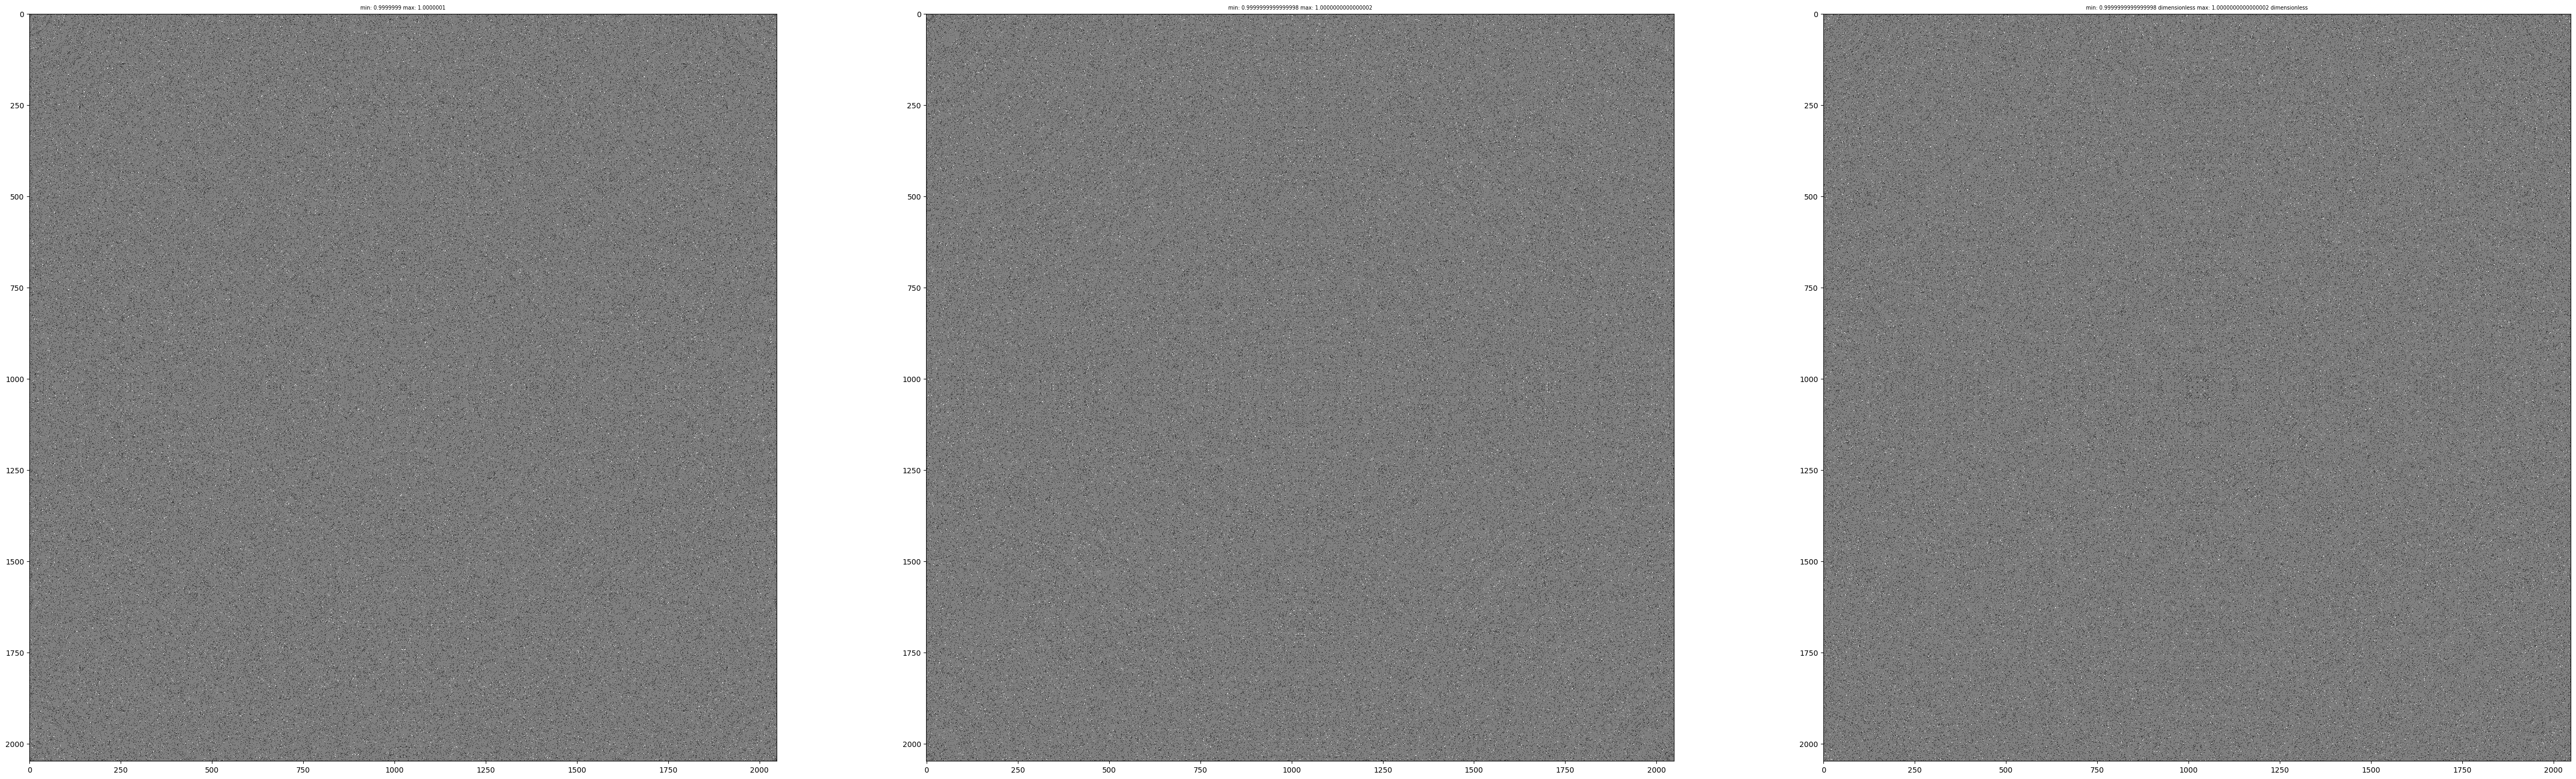

In [14]:
ff_ganrec = ffactor(px, energy, z, pv)
ff_pyphase = simple_propagator(px, py, 1, [pv, pv], lam, [z])[0]
ff_paper = fresnel_operator(px, py, pv, z, energy)
lib.visualize([ffactor(px, energy, z, pv), simple_propagator(px, py, 1, [pv, pv], lam, [z])[0], fresnel_operator(px, py, pv, z, energy)])

# <u> <b>  CONCLUSION </b> </u>

> #### Even though the Fresnel operator in GanREC is different that the two other operators, they all result in a similar propation property, and hence can be used without a problem